# Global Coffee Health: End-to-End ML Pipeline (Classification)
## by Yegorchenkov Platon (GH1024875)
- GitHub URL: https://github.com/baby-platom/uni-ai-ml
- Dataset source URL: https://www.kaggle.com/datasets/uom190346a/global-coffee-health-dataset

## Problem Statement
A coffee company wants to be able to predict the **sleep quality** of the customers. In case the anticipated **sleep quality** is low, the health routines (lower-caffeine options, decaff, personalized recommendation) can be promoted to the customers. If we can relatively reliably anticipate the poor sleep, we could:
- `Reduce churn rates & increase the Lifetime Value`: if we proactively handle the at-risk users, we can suggest healthier consumption patterns
- `Boost customer wellbeing`: if there're fewer sleep complaints, the sattisfaction and brand trust are on the higher levels
- `Tailor the products`: target content and the related recommendations based on a risk level

### Data collection
The data, in practice, could originate from
- User profile: age, gender, country, occupation
- Habit tracking: the number of cups per day, physical activities, the bad habits
- Wearables: heart rate, sleep hours

In practice, we have an already collected dataset with the numerous rich features

### Goal
Predict **sleep quality** (Excellent / Good / Fair / Poor) based on the lifestyle, coffee consumption and demographics. 

### ML task
Multitask classification to predict `Sleep_Quality ∈ {Excellent, Good, Fair, Poor}`

### Success criteria
We want to get the balanced performance across the classes (not just the majority). Use `Macro-F1` and `Balanced Accuracy` as the primary metrics. Additionally, use confusion matrix and classification report (precision, recall, and F1 for each class).


## Data Exploration

In [ ]:
from pathlib import Path

import pandas as pd

SEED = 42

data_path = Path("dataset.csv")
df = pd.read_csv(data_path)

df.head()

,ID,Age,Gender,Country,Coffee_Intake,Caffeine_mg,Sleep_Hours,Sleep_Quality,BMI,Heart_Rate,Stress_Level,Physical_Activity_Hours,Health_Issues,Occupation,Smoking,Alcohol_Consumption
0,1,40,Male,Germany,3.5,328.1,7.5,Good,24.9,78,Low,14.5,NaN,Other,0,0
1,2,33,Male,Germany,1.0,94.1,6.2,Good,20.0,67,Low,11.0,NaN,Service,0,0
2,3,42,Male,Brazil,5.3,503.7,5.9,Fair,22.7,59,Medium,11.2,Mild,Office,0,0
3,4,53,Male,Germany,2.6,249.2,7.3,Good,24.7,71,Low,6.6,Mild,Other,0,0
4,5,32,Female,Spain,3.1,298.0,5.3,Fair,24.1,76,Medium,8.5,Mild,Student,0,1


In [42]:
df.shape, df.dtypes

((10000, 16),
 ID                           int64
 Age                          int64
 Gender                      object
 Country                     object
 Coffee_Intake              float64
 Caffeine_mg                float64
 Sleep_Hours                float64
 Sleep_Quality               object
 BMI                        float64
 Heart_Rate                   int64
 Stress_Level                object
 Physical_Activity_Hours    float64
 Health_Issues               object
 Occupation                  object
 Smoking                      int64
 Alcohol_Consumption          int64
 dtype: object)

In [43]:
missing = df.isna().sum().sort_values(ascending=False)
duplicates = df.duplicated().sum()
missing, duplicates

(Health_Issues              5941
 ID                            0
 Age                           0
 Gender                        0
 Country                       0
 Coffee_Intake                 0
 Caffeine_mg                   0
 Sleep_Hours                   0
 Sleep_Quality                 0
 BMI                           0
 Heart_Rate                    0
 Stress_Level                  0
 Physical_Activity_Hours       0
 Occupation                    0
 Smoking                       0
 Alcohol_Consumption           0
 dtype: int64,
 np.int64(0))

The only column that has "missing values" is `Health_Issues`. However, when a cell in the `Health_Issues` column is `NaN`, it means that a person just has no health issues. 

Since for categorical features we will use a `OneHotEncoder`, it will encode it just as one of the categories. Considering that there're 10 thousand rows in total, the 5941 records with no `Health_Issues` is the most popular category for this feature.

We also have no duplicates

### Dependent variable distribution

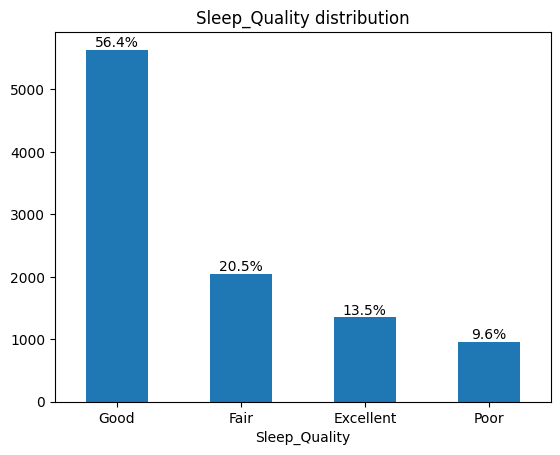

In [44]:
import matplotlib.pyplot as plt

ax = df["Sleep_Quality"].value_counts().plot(kind="bar", rot=0)
ax.set_title("Sleep_Quality distribution")

total = len(df)
for p in ax.patches:
    height = p.get_height()
    percent = f"{height / total:.1%}"
    ax.text(p.get_x() + p.get_width() / 2, height, percent, ha="center", va="bottom")

plt.show()

We can observe that the `Sleep_Quality` is imbalanced, though not extremely:
- `Good` makes up over a half of the observed cases
- `Poor` accounts for less than 10%

To handle this, we will use `stratified splits` to ensure that the class proportions remain the same within the subsets. We are using `Macro-F1`, so the classes are threated equally within the model, so the imbalance is treated.

## Leakage

In [45]:
df.groupby("Sleep_Quality")["Sleep_Hours"].agg(["mean", "std", "count"])

,mean,std,count
Sleep_Quality,,,
Excellent,8.593565,0.499959,1352
Fair,5.576732,0.278688,2050
Good,6.924446,0.549481,5637
Poor,4.451925,0.456320,961


The `Sleep_Quality` is likely a binning of `Sleep_Hours`:
- Excellent ≈ 8.59h
- Good ≈ 6.92h
- Fair ≈ 5.58h
- Poor ≈ 4.45h

Except for the **Monotonic ordering** (the higher sleep hours mean better quality) we also observe:
- Small standard deviation: every group has tight clustering
- Clear thresholds: the mean values are near the integer values, like bins boundaries

So, it's very likely that the `Sleep_Quality` is derived from `Sleep_Hours`. To avoid the leakage, we will drop the `Sleep_Hours`.

In [46]:
pd.crosstab(df["Sleep_Quality"], df["Stress_Level"])

Stress_Level,High,Low,Medium
Sleep_Quality,,,
Excellent,0,1352,0
Fair,0,0,2050
Good,0,5637,0
Poor,961,0,0


It's another leakege and here it's perfect: every `Sleep_Quality` level is strictly matched with a corresponding `Stress_Level`. We will also drop the `Stress_Level`.

## Redundancy analysis

In [47]:
(df[["Caffeine_mg", "Coffee_Intake"]].corr().iloc[0, 1])

np.float64(0.9998135731303948)

The correlation between `Caffeine_mg` and `Coffee_Intake` is extremely high, we could anticipate that. One of the columns is redundant, we will keep `Coffee_Intake` (it's easier to interpret) and drop the `Caffeine_mg`

In [48]:
pd.crosstab(df["Health_Issues"], df["Sleep_Quality"], normalize="index", dropna=False)

Sleep_Quality,Excellent,Fair,Good,Poor
Health_Issues,,,,
Mild,0.060352,0.491199,0.221011,0.227438
Moderate,0.012959,0.600432,0.075594,0.311015
Severe,0.000000,0.823529,0.000000,0.176471
NaN,0.190204,0.000000,0.809796,0.000000


The `Health_Issues` seems to be highly alligned with the `Sleep_Quality`. So the `Health_Issues` is not an independent predictor. This may dominate and mask the other casual effects in the model.

To be conservative about causality, we'll check the model without (excluding) the `Health_Issues` during the sensitivity analysis. 

## Numeric relationships

In [49]:
num = df.select_dtypes("number").drop(columns=["ID"])
num.corr()["Sleep_Hours"].sort_values(ascending=False)

Sleep_Hours                1.000000
BMI                        0.008463
Smoking                    0.007955
Age                        0.005010
Alcohol_Consumption       -0.003375
Physical_Activity_Hours   -0.011228
Heart_Rate                -0.036219
Coffee_Intake             -0.190291
Caffeine_mg               -0.190493
Name: Sleep_Hours, dtype: float64

The strongest correlations are among `Coffee_Intake` and `Caffeine_mg`: about `-0.190` for each. Though it reflects that the people consuming more caffeine tend to sleep less, the correlation is weak. 